In [1]:
from env import *

## Read data and select learners

In [2]:
lcdb_df = pd.read_csv(os.path.expanduser('~/Documents/data/delegated_classification/lcdb/database/database-accuracy.csv'))
lcdb_df.head()

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
0,44,SVC_linear,16,461,0,0,0.0024,0.8750,0.7440,0.7072
1,44,SVC_linear,23,461,0,0,0.0014,0.9565,0.7222,0.6876
2,44,SVC_linear,32,461,0,0,0.0017,0.9375,0.7295,0.7180
3,44,SVC_linear,45,461,0,0,0.0023,0.9778,0.8237,0.8048
4,44,SVC_linear,64,461,0,0,0.0033,0.7812,0.6280,0.6508


In [3]:
selected_learners = np.array([
    'sklearn.neural_network.MLPClassifier',
    'sklearn.ensemble.GradientBoostingClassifier',
])

selected_openmlid = dclf.mnist_openmlid

## Select learners

[None,
 Text(0.5, 0, 'Training set size $n$'),
 Text(0, 0.5, 'Test-set accuracy $\\mathrm{acc}(n)$'),
 Text(0.5, 1.0, 'MNIST learning curves')]

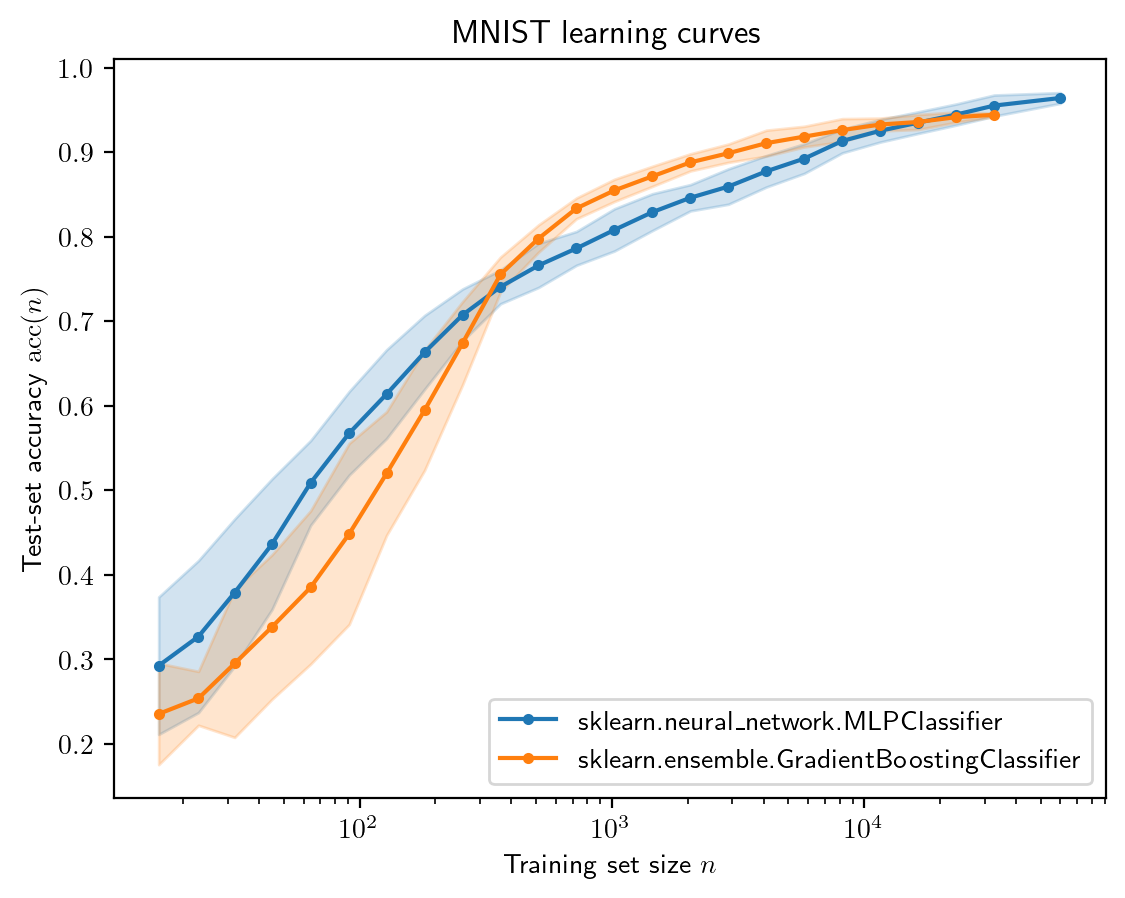

In [4]:
fig,ax=plt.subplots()
plot_learning_curve = lambda learner, ax: (
    lcdb_df
    .query('openmlid==@selected_openmlid and learner==@learner')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .apply(dclf.describe_series_of_samples)
    .pipe(
        dclf.df_plot_curve_with_band,
        mean='mean',
        lb='std_lb',
        ub='std_ub',
        ax=ax,
        label=learner,
        marker='.',
    )
)

for learner in selected_learners:
    plot_learning_curve(learner,ax=ax)

ax.legend()
ax.set(
    xscale='log',
    xlabel='Training set size $n$',
    ylabel='Test-set accuracy $\\mathrm{acc}(n)$',
    title=f'MNIST learning curves'
)


## Utility functions

In [5]:
closest_ind = lambda arr, val: np.argmin(np.abs(np.array(arr)-val))

build_cdp = lambda learner, m: (
    lcdb_df
    .query('openmlid==@selected_openmlid and learner==@learner')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .pipe(
        dclf.BootstrappedBinomialMixtureContractDesignProblem.from_series,
        m=m,
        ensure_zero_cost_action=True,
    )
)


## Compute grid

In [6]:
m_vec = np.hstack([np.arange(1,10), np.arange(10,20,2), np.arange(20,51,4)])
param(max(m_vec),'max_m')
print('m_vec:',m_vec)

n_vec = np.array(build_cdp(learner, m=1).cost)
actions_vec = np.arange(4,len(n_vec))
print('actions:',n_vec[actions_vec])

contract_types = {
    'min_budget_hybrid': dclf.MinBudgetHybridContract.design,
}

m_results = []
for m in tqdm(m_vec):
    for learner in selected_learners:
        cdp = build_cdp(learner, m=m)
        for action, contract_type in itertools.product(
            actions_vec,
            contract_types,
        ):
            try:
                contract = contract_types[contract_type](
                    cdp,
                    target_action=action,
                )
            except (RuntimeError, ZeroDivisionError):
                continue
            if contract['t'][0]==None:
                continue
            response = dclf.get_agent_response(
                cdp,
                contract['t'],
            )
            if not response.selected_action>=action:
                # raise RuntimeError
                continue
            m_results.append({
                'm': m,
                'contract_type': contract_type,
                'learner': learner,
                'action': action,
                'n': cdp.cost[action],
                'n_acc': cdp.mean_acc[action],
                'B':contract['t'].max(),
                'selected_action_utility':response.selected_action_utility,
                'selected_action_cost':response.selected_action_cost,
                'expected_pay':response.expected_pay,
                'cdp':cdp,
                'contract':contract,
                'is_local':contract.get('solver',None)=='sba',
                'is_threshold':dclf.is_threshold(contract['t']),
                'response':response,
            })
            
m_results_df = pd.DataFrame(m_results)
m_results_df.head()

m_vec: [ 1  2  3  4  5  6  7  8  9 10 12 14 16 18 20 24 28 32 36 40 44 48]
actions: [   45    64    91   128   181   256   362   512   724  1024  1448  2048
  2896  4096  5793  8192 11585 16384 23170 32768]


  0%|          | 0/22 [00:00<?, ?it/s]

,m,contract_type,learner,action,n,n_acc,B,selected_action_utility,selected_action_cost,expected_pay,cdp,contract,is_local,is_threshold,response
0,1,min_budget_hybrid,sklearn.neural_network.MLPClassifier,4,45,0.436160,226.702009,53.878348,45,98.878348,<dclf.common_types.BootstrappedBinomialMixture...,"{'t': [0.0, 226.70200892857142], 'budget': 226...",True,True,"RationalChoice(utility=array([ 0.00000000e+00,..."
1,1,min_budget_hybrid,sklearn.neural_network.MLPClassifier,5,64,0.508680,261.996691,69.272477,64,133.272477,<dclf.common_types.BootstrappedBinomialMixture...,"{'t': [0.0, 261.9966905681184], 'budget': 261....",True,True,"RationalChoice(utility=array([ 0.00000000e+00,..."
2,1,min_budget_hybrid,sklearn.neural_network.MLPClassifier,6,91,0.567384,459.934587,169.959526,91,260.959526,<dclf.common_types.BootstrappedBinomialMixture...,"{'t': [0.0, 459.93458708095017], 'budget': 459...",True,True,"RationalChoice(utility=array([ 0.00000000e+00,..."
3,1,min_budget_hybrid,sklearn.neural_network.MLPClassifier,7,128,0.613696,798.929003,362.299534,128,490.299534,<dclf.common_types.BootstrappedBinomialMixture...,"{'t': [0.0, 798.9290032820854], 'budget': 798....",True,True,"RationalChoice(utility=array([ 0. ,..."
4,1,min_budget_hybrid,sklearn.neural_network.MLPClassifier,8,181,0.663096,1072.874494,530.418785,181,711.418785,<dclf.common_types.BootstrappedBinomialMixture...,"{'t': [0.0, 1072.8744939271248], 'budget': 107...",True,True,"RationalChoice(utility=array([ 0. ,..."


## Plot results

0.8460639999999999
0.8547999999999998
Figure saved as ./output/full_information_contract_analysis.pdf


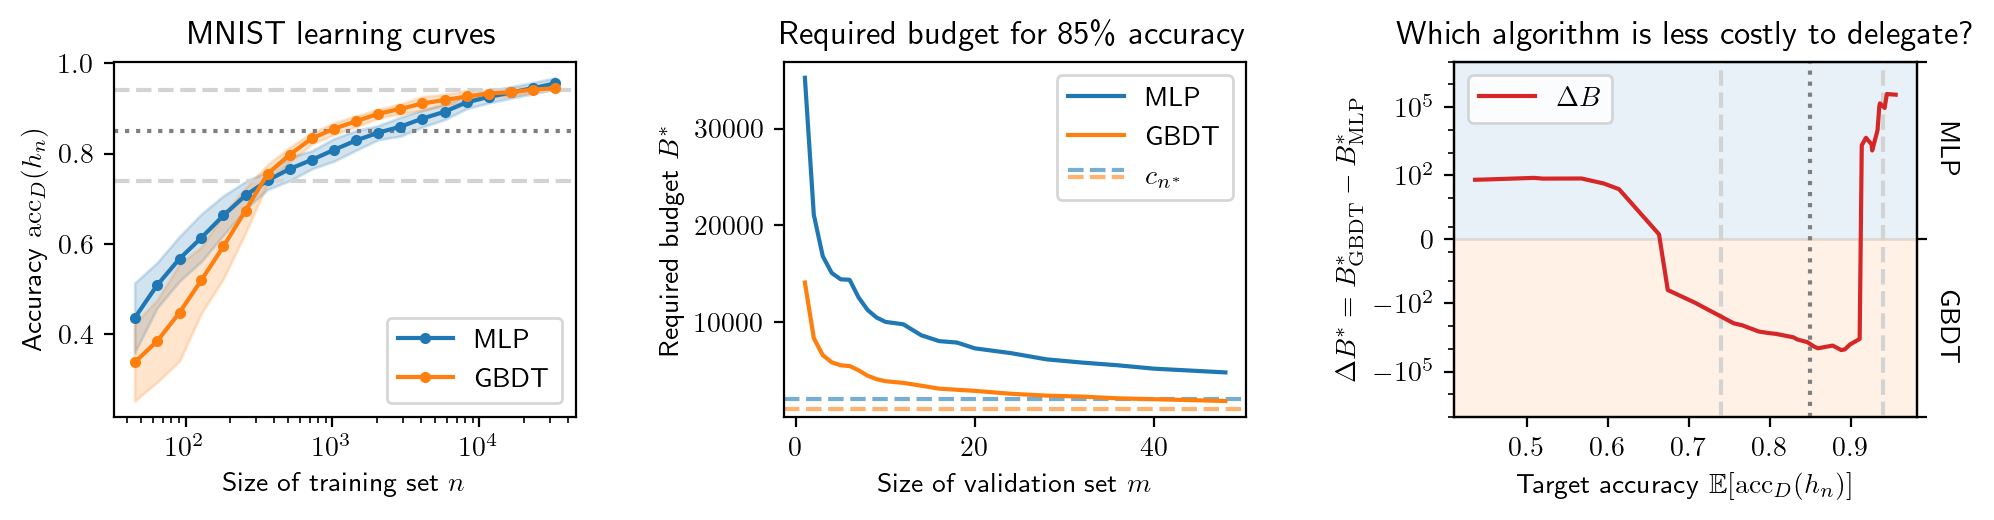

In [7]:
fig,axs=plt.subplots(1,3,figsize=(10,2.7), tight_layout={'w_pad':3})

axs_it = iter(axs.ravel())

model_accuracy_label = 'Accuracy $\\mathrm{acc}_D(h_n)$'
target_accuracy_label = 'Target accuracy $\\mathbb{E}[\\mathrm{acc}_D(h_n)]$'
training_set_size_label = 'Size of training set $n$'

#
# Learning curves
#
ax = next(axs_it)

plot_learning_curve = lambda learner, ax: (
    lcdb_df
    .query('openmlid==@selected_openmlid and learner==@learner and size_train in @n_vec[@actions_vec]')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .apply(dclf.describe_series_of_samples)
    .pipe(
        dclf.df_plot_curve_with_band,
        mean='mean',
        lb='std_lb',
        ub='std_ub',
        ax=ax,
        label=dclf.lcdb_learner_names[learner],
        marker='.',
    )
)

for learner in selected_learners:
    plot_learning_curve(learner,ax=ax)

crossing_accs = [
    param(0.74,'crossing_point_low'),
    param(0.94,'crossing_point_high'),
]

crossing_n = [
    param(cdp.cost[closest_ind(cdp.mean_acc,crossing_accs[0])], 'crossing_n_low'),
    param(cdp.cost[closest_ind(cdp.mean_acc,crossing_accs[1])], 'crossing_n_high'),
]

crossing_n_log = [
    param((np.log2(crossing_n[0])*2).round().astype(int), 'crossing_twologn_low'),
    param((np.log2(crossing_n[1])*2).round().astype(int), 'crossing_twologn_high'),
]

def plot_crossing_accs(ax, orientation):   
    plot = {
        'v': ax.axvline,
        'h': ax.axhline,
    }
    for i,crossing_acc in enumerate(crossing_accs):
        plot[orientation](
            crossing_acc,
            # label=f'${target_acc*100:g}\\%$ accuracy',
            # label='Curves crossing' if i==0 else None,
            linestyle='--',
            color='lightgray',
            zorder=-1,
        )


plot_crossing_accs(ax,'h')
    
m_target_acc = param(0.85,'m_target_acc')

ax.axhline(
    m_target_acc,
    linestyle=':',
    # label=f'${m_target_acc*100:g}\\%$ accuracy',
    color='tab:gray',
    zorder=-1,
)

ax.legend()
ax.set(
    xscale='log',
    xlabel=training_set_size_label,
    ylabel=model_accuracy_label,
    title=f'MNIST learning curves'
)

#
# Size of validation set
#

ax = next(axs_it)


styles = [
    ['tab:blue','-','v'],
    ['tab:blue','--','^'],
    ['tab:orange','-',7],
    ['tab:orange','--',6],
]

solver_names = {
    # 'min_budget_lp': 'Full LP',
    # 'min_budget_local': 'Local solver',
    'min_budget_hybrid': 'Hybrid solver',
}
lb_linestyle = {
    # 'linestyle':(0, (5, 1)),
    # 'linestyle':(0, (1, 1)),
    'linestyle':'--',
    'alpha':0.6,
}

for i,learner in enumerate(selected_learners):
    cdp = build_cdp(learner,m=1)
    target_n = cdp.cost[closest_ind(cdp.mean_acc, m_target_acc)]
    print(cdp.mean_acc[closest_ind(cdp.mean_acc, m_target_acc)])
    learner_name = dclf.lcdb_learner_names[learner]
    for j,contract_type in enumerate(contract_types):
        (
            m_results_df
            .query('n==@target_n and learner==@learner and contract_type==@contract_type')
            .set_index('m')
            ['B']
            .plot.line(
                ax=ax,
                color=styles[2*i+j][0],
                linestyle=styles[2*i+j][1],
                # label=f'{learner_name} - {solver_names.get(contract_type, contract_type)}',
                label=f'{learner_name}',
            )
        )
        
    ax.axhline(
        target_n,
        # label=f'{learner_name} lower bound',
        color=styles[2*i][0],
        **lb_linestyle,
    )
    
ax.legend()
handles, labels = ax.get_legend_handles_labels()
lc = matplotlib.collections.LineCollection(
    [[(0,0)]]*2,
    linestyles=[(0.4,(2.5,1))]*2,
    colors=['tab:blue','tab:orange'],
    alpha=lb_linestyle['alpha'],
    label='$c_{n^*}$',
)
handles.append(lc)
ax.legend(handles=handles, handler_map={type(lc): dclf.HandlerDashedLines()})

ax.set(
    title=f'Required budget for {m_target_acc*100:g}\\% accuracy',
    xlabel='Size of validation set $m$',
    ylabel='Required budget $B^*$',
    # yscale='log',
)


#
# Algorithm budget comparison
#
def plot_algorithm_budget_comparison(ax):
    delta_b_selected_m = param(20, 'delta_b_selected_m')

    required_budget_per_acc = (
        m_results_df
        .query('m==@delta_b_selected_m and contract_type=="min_budget_hybrid"')
        .pivot(
            index='n_acc',
            columns='learner',
            values='B',
        )
        [selected_learners]
        .rename(dclf.lcdb_learner_names, axis=1)
        .interpolate(method='index')
    )
    (
        required_budget_per_acc
        .diff(axis=1)
        .iloc[:,-1]
        .rename(
            '$\\Delta B$'
        )
        .plot.line(
            ax=ax,
            color='tab:red',
            title='Which algorithm is less costly to delegate?',
            xlabel=target_accuracy_label,
            ylabel='$\\Delta B^* = B^*_\\mathrm{GBDT}-B^*_\\mathrm{MLP}$',
        )
    )

    plot_crossing_accs(ax,'v')
    ax.axvline(
        m_target_acc,
        linestyle=':',
        color='tab:gray',
        zorder=-1,
    )

    ax.set_yscale('symlog')
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator([-1e8,-1e5,-1e2,0,1e2,1e5,1e8]))
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
    ylim = np.array([-1,1])*1e7
    ax.set_ylim(ylim)
    xlim = ax.get_xlim()

    alpha = 0.1

    twinx = ax.twinx()

    twinx.fill_between(
        x=[0,1],
        y1=1,
        y2=0,
        color='tab:blue',
        alpha=alpha,
        label='MLP is cheaper',
    )

    twinx.fill_between(
        x=[0,1],
        y1=-1,
        y2=0,
        color='tab:orange',
        alpha=alpha,
        label='GBDT is cheaper',
    )

    twinx.set_ylim([-1,1])

    twinx.set_yticks(
        [-1,0,1],
        ['']*3,
    )
    twinx.set_yticks(
        [0.5,-0.5],
        [f'{dclf.lcdb_learner_names[l]}' for l in selected_learners],
        minor=True,
        rotation=270,
        ha='left',
        va='center',
        x=1.02,
    )

    twinx.tick_params(axis='y', which='minor', length=0)
    ax.set_xlim(xlim)
    ax.set_zorder(10)
    ax.patch.set_visible(False)
    ax.legend()

ax = next(axs_it)
plot_algorithm_budget_comparison(ax=ax)
    
dclf.save_and_download_fig(fig,'./output/full_information_contract_analysis.pdf')
tracker.save('./output/full_information.json')


In [8]:
(
    m_results_df
    [['is_local','is_threshold']]
    .value_counts()
    .pipe(lambda s: s/s.sum())
)

is_local  is_threshold
True      True            0.781755
False     False           0.184758
          True            0.033487
Name: count, dtype: float64

In [9]:
print('Composition of SBA threshold solutions for required budget graph')
for learner in selected_learners:
    cdp = build_cdp(learner,m=1)
    target_n = cdp.cost[closest_ind(cdp.mean_acc, m_target_acc)]
    print(f'{learner}:')
    print(
        m_results_df
        .query('n==@target_n and contract_type==@contract_type and learner==@learner')
        [['is_local','is_threshold']]
        .value_counts()
        # .to_dict()
    )

Composition of SBA threshold solutions for required budget graph
sklearn.neural_network.MLPClassifier:
is_local  is_threshold
True      True            22
Name: count, dtype: int64
sklearn.ensemble.GradientBoostingClassifier:
is_local  is_threshold
True      True            22
Name: count, dtype: int64


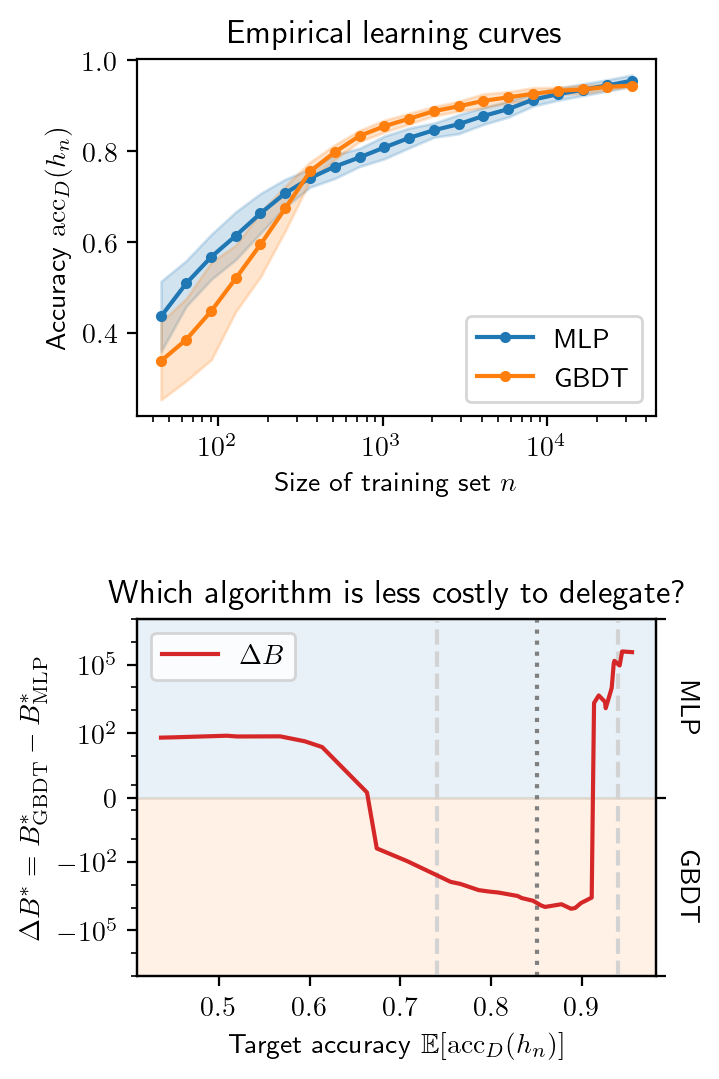

In [10]:
fig,axs = plt.subplots(2,1,figsize=(3.7,5.5),tight_layout={'w_pad':2,'h_pad':3})
axs_it = iter(axs.ravel())

ax = next(axs_it)
for learner in selected_learners:
    plot_learning_curve(learner,ax=ax)
ax.legend()
ax.set(
    xscale='log',
    xlabel=training_set_size_label,
    ylabel=model_accuracy_label,
    title=f'Empirical learning curves'
)

ax = next(axs_it)
plot_algorithm_budget_comparison(ax=ax)
dclf.download_fig(fig,'algorithm_budget_comparison.pdf')